In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import f_oneway, mannwhitneyu
from scipy import stats

In [2]:
df = pd.read_csv('preeliminary_data.csv')
df.dropna(inplace=True)

df.head()


,Round,Day of measurement,ID,Group,Weight (g),pH,Bubbles (mm)
0,1,Day 0,1,Br,460.0,4.2,0.0
1,1,Day 1,1,Br,460.0,3.3,32.0
2,1,Day 2,1,Br,480.0,3.2,46.0
3,1,Day 3,1,Br,520.0,3.1,10.0
4,1,Day 0,2,Br,440.0,4.3,0.0


In [24]:
# ANOVA on weight 
anova_w = f_oneway(df[df['Group']=='Br']['Weight (g)'], df[df['Group']=='W']['Weight (g)'])

F_onewayResult(statistic=3.6730310262529837, pvalue=0.06284321875866812)

In [34]:
anova_b = f_oneway(df[df['Group']=='Br']['Bubbles (mm)'], df[df['Group']=='W']['Bubbles (mm)'])
anova_b

F_onewayResult(statistic=0.0018047969603419618, pvalue=0.9663361865862545)

In [38]:
anova_p = f_oneway(df[df['Group']=='Br']['pH'], df[df['Group']=='W']['pH'])
anova_p

F_onewayResult(statistic=-1.7347635647221334e-30, pvalue=nan)

In [37]:
# Mann-Whitney U test on pH and Bubbles since non-normal
man_p = mannwhitneyu(df[df['Group']=='Br']['pH'], df[df['Group']=='W']['pH'])
man_p


MannwhitneyuResult(statistic=203.0, pvalue=0.9458706132684596)

In [27]:
man_b = mannwhitneyu(df[df['Group']=='Br']['Bubbles (mm)'], df[df['Group']=='W']['Bubbles (mm)'])

MannwhitneyuResult(statistic=200.5, pvalue=1.0)

In [32]:
man_w = mannwhitneyu(df[df['Group']=='Br']['Weight (g)'], df[df['Group']=='W']['Weight (g)'])
man_w

MannwhitneyuResult(statistic=136.5, pvalue=0.08363206039065939)

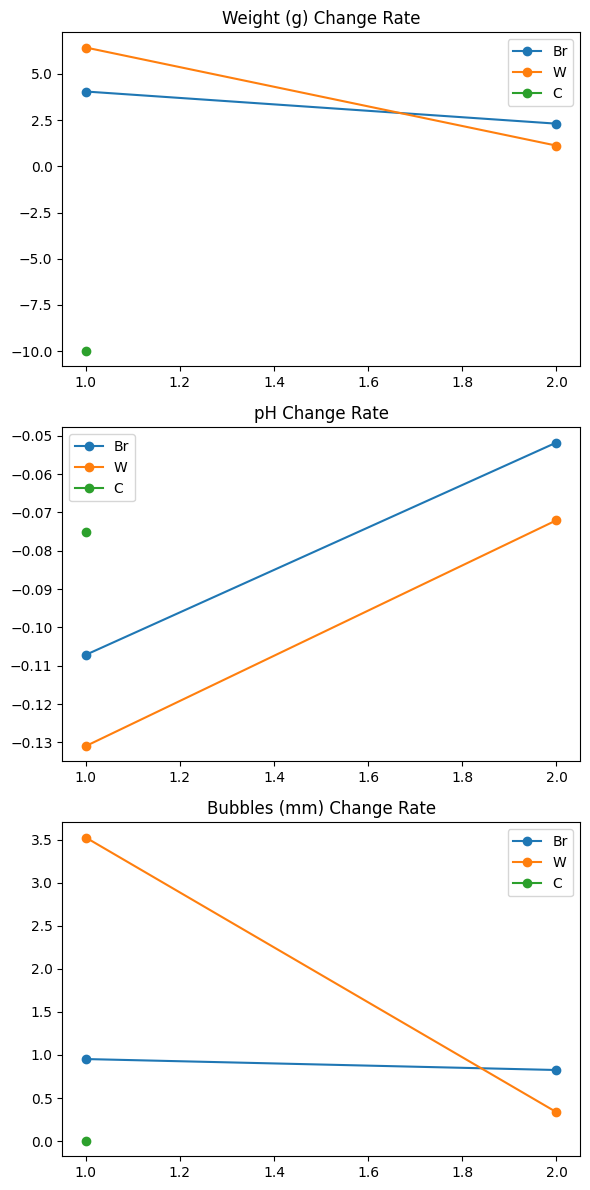

Average slope for Weight (g):
Round
1    0.158730
2    1.713287
Name: Weight (g), dtype: float64
Average slope for pH:
Round
1   -0.104365
2   -0.061888
Name: pH, dtype: float64
Average slope for Bubbles (mm):
Round
1    1.492063
2    0.580420
Name: Bubbles (mm), dtype: float64


In [30]:
def get_slope(series):
    return stats.linregress(series.index, series).slope

slopes = df.groupby(['Round', 'Group']).apply(lambda x: x[['Weight (g)', 'pH', 'Bubbles (mm)']].apply(get_slope))

# Plotting
fig, axs = plt.subplots(3, figsize=(6, 12))

for i, metric in enumerate(['Weight (g)', 'pH', 'Bubbles (mm)']):
    for group in df['Group'].unique():
        group_slopes = slopes.xs(group, level='Group')[metric]
        axs[i].plot(group_slopes.index, group_slopes.values, label=group, marker='o')
    
    axs[i].set_title(f'{metric} Change Rate')
    axs[i].legend()

plt.tight_layout()
plt.show()

# Print average slope comparison
for metric in ['Weight (g)', 'pH', 'Bubbles (mm)']:
    print(f"Average slope for {metric}:")
    print(slopes[metric].groupby('Round').mean())

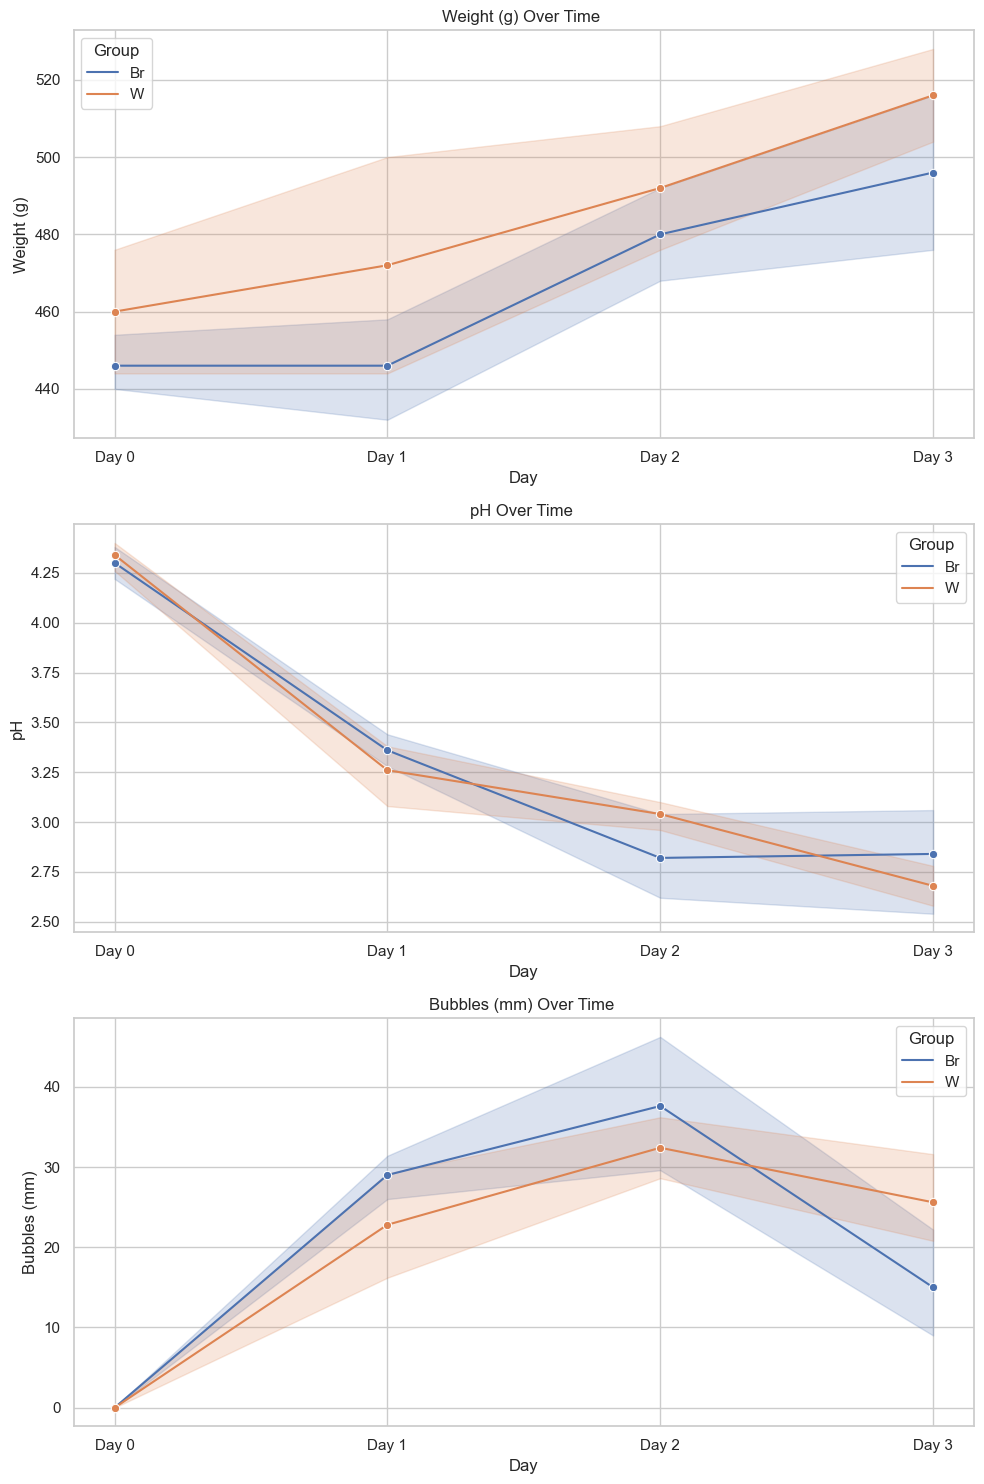

In [6]:
df_filtered = df[df['Group'] != 'C']

# Setting seaborn style for better aesthetics
sns.set(style="whitegrid")

# Creating line plots for 'Weight (g)', 'pH', and 'Bubbles (mm)' against 'Day' for the remaining groups
metrics = ['Weight (g)', 'pH', 'Bubbles (mm)']
fig, axs = plt.subplots(len(metrics), 1, figsize=(10, 15))  # Adjust the size as needed

for i, metric in enumerate(metrics):
    sns.lineplot(data=df_filtered, x='Day of measurement', y=metric, hue='Group', marker='o', ax=axs[i])
    axs[i].set_title(f'{metric} Over Time ')  # Title for each subplot
    axs[i].set_ylabel(metric)  # Y-label for each metric
    axs[i].set_xlabel('Day')  # X-label for days
    axs[i].legend(title='Group')  # Legend for groups

plt.tight_layout()  # Adjusts the plots to fit nicely in the figure
plt.show()  # Displays the plots

C:\Users\Rebe\AppData\Local\Temp\ipykernel_21092\3517901627.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Weight_change'] = df_filtered.groupby(['Round', 'ID'])['Weight (g)'].diff().fillna(0)
C:\Users\Rebe\AppData\Local\Temp\ipykernel_21092\3517901627.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['CO2_weight_change'] = df_filtered['Weight_change'] - daily_feed_weight


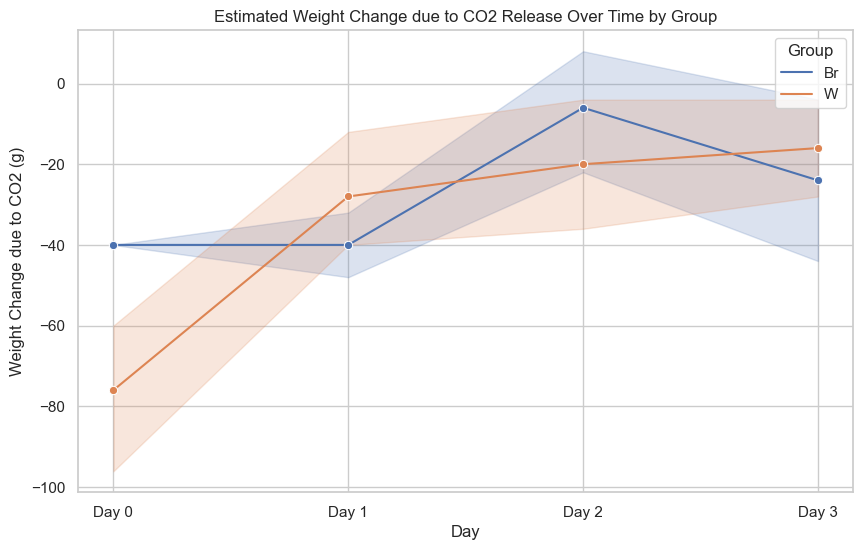

In [8]:
# Total daily feed weight (20g sugar + 20g ginger)
daily_feed_weight = 40  # 40 grams added each day

# Calculate daily weight change
df_filtered['Weight_change'] = df_filtered.groupby(['Round', 'ID'])['Weight (g)'].diff().fillna(0)

# Estimate weight change due to CO2 release
# Subtract daily feed weight from the total weight change
df_filtered['CO2_weight_change'] = df_filtered['Weight_change'] - daily_feed_weight

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.lineplot(data=df_filtered, x='Day of measurement', y='CO2_weight_change', hue='Group', marker='o')
plt.title('Estimated Weight Change due to CO2 Release Over Time by Group')
plt.ylabel('Weight Change due to CO2 (g)')
plt.xlabel('Day')
plt.legend(title='Group')
plt.show()


In [9]:
from scipy.stats import shapiro, levene, mannwhitneyu
import pandas as pd

df_no_C = df[df['Group'] != 'C']

# Assuming df_cleaned is your cleaned DataFrame and metrics are defined as before
metrics = ['Weight (g)', 'pH', 'Bubbles (mm)']

# Check for normality and homogeneity of variances for each metric
tests_results = {}
for metric in metrics:
    # Normality test (Shapiro-Wilk)
    w_stat, p_value_norm = shapiro(df_no_C[metric])
    normality = p_value_norm > 0.05  # Assuming alpha = 0.05

    # Homogeneity of variances (Levene's test)
    levene_stat, p_value_levene = levene(*[group[metric] for name, group in df_no_C.groupby('Group')])
    homogeneity = p_value_levene > 0.05  # Assuming alpha = 0.05

    tests_results[metric] = {"Normality": normality, "Homogeneity": homogeneity}

# Mann-Whitney U Test for each metric between each pair of groups (excluding group 'C')
mann_whitney_results = {}
for metric in metrics:
    groups = df_no_C['Group'].unique()
    for i in range(len(groups)):
        for j in range(i + 1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
            stat, p = mannwhitneyu(df_no_C[df_no_C['Group'] == group1][metric],
                                    df_no_C[df_no_C['Group'] == group2][metric])
            key = f"{metric} ({group1} vs {group2})"
            mann_whitney_results[key] = {'U-Statistic': stat, 'p-value': p, 'Reject Null': p < 0.05}

# Creating DataFrames for the results
mwu_df = pd.DataFrame.from_dict(mann_whitney_results, orient='index')
normality_method_results = {}
for metric in metrics:
    is_normal = tests_results[metric]['Normality']
    suggested_method = "Parametric methods (e.g.,ANOVA)" if is_normal else "Non-parametric methods (e.g., Mann-Whitney U)"
    normality_method_results[metric] = {'Normality': is_normal, 'Suggested Method': suggested_method}
norm_method_df = pd.DataFrame.from_dict(normality_method_results, orient='index')

# Printing the results
print("Mann-Whitney U Test Results:")
print(mwu_df)
print("\nNormality Test Results and Suggested Methods:")
print(norm_method_df)


Mann-Whitney U Test Results:
                        U-Statistic   p-value  Reject Null
Weight (g) (Br vs W)          136.5  0.083632        False
pH (Br vs W)                  203.0  0.945871        False
Bubbles (mm) (Br vs W)        200.5  1.000000        False

Normality Test Results and Suggested Methods:
              Normality                                   Suggested Method
Weight (g)        False  Non-parametric methods (e.g., Mann-Whitney U, ...
pH                False  Non-parametric methods (e.g., Mann-Whitney U, ...
Bubbles (mm)      False  Non-parametric methods (e.g., Mann-Whitney U, ...


In [11]:
norm_method_df

,Normality,Suggested Method
Weight (g),False,"Non-parametric methods (e.g., Mann-Whitney U, ..."
pH,False,"Non-parametric methods (e.g., Mann-Whitney U, ..."
Bubbles (mm),False,"Non-parametric methods (e.g., Mann-Whitney U, ..."


In [12]:
mwu_df

,U-Statistic,p-value,Reject Null
Weight (g) (Br vs W),136.5,0.083632,False
pH (Br vs W),203.0,0.945871,False
Bubbles (mm) (Br vs W),200.5,1.000000,False
